This code reads the GeneratedParticles branch of the tree provided by a neutral current reaction simulation.

First, we import the requisite ROOT libraries.

In [7]:
import ROOT
from ROOT import TFile, TTree, TLorentzVector, TH1F, TCanvas, TPad, TGraph

Now, we can access the root file containing the simulation and get the `events` tree saved within.

Then, we create a pointer to the PDG leaf, which contains the Monte Carlo particle numbers of each particle, as well as some dictionaries that map each number to the corresponding particle name. We also create a dictionary that stores the amount of each particle.

In [8]:
filename = 'pythia8NCDIS_10x100_minQ2=100_beamEffects_xAngle=-0.025_hiDiv_vtxfix_1_000.0002.eicrecon.tree.edm4eic.root'
file = TFile(filename)

tree = file.Get('events')

In [9]:
pdg = tree.GetLeaf('GeneratedParticles.PDG')

particles_def = {11: 'electron',
                 22: 'gamma particle',
                 130: 'KL-neutral meson',
                 211: 'pi+ meson',
                 321: 'K+ meson',
                 2112: 'neutron',
                 2212: 'proton'}
particles_count = {'electron': 0,
                   'gamma particle': 0,
                   'pi+ meson': 0,
                   'KL-neutral meson': 0,
                   'K+ meson': 0,
                   'neutron': 0,
                   'proton': 0,
                   'other': 0}

This logic will iterate through the tree and then each entry in the leaf. Through this iteration, we can find the number of each particle in the simulation. In the case that we encounter a particle not listed in the `particles_def` dictionary, we add one to the `other` entry in the count dictionary.

In [10]:
for ev in tree:
    for i in range(pdg.GetLen()):
        key = abs(int(pdg.GetValue(i)))
        if key in particles_def.keys():
            particles_count[particles_def[key]] += 1
        else:
            particles_count['other'] += 1

for key, value in particles_count.items():
    print(f'Number of {key}s: {value}')

Number of electrons: 2633
Number of gamma particles: 19403
Number of pi+ mesons: 15968
Number of KL-neutral mesons: 765
Number of K+ mesons: 1617
Number of neutrons: 1868
Number of protons: 2174
Number of others: 83


We can now plot these values in a bar chart by using the frequency of each particle. To do this, we use the `numpy` and `matplotlib` libraries.

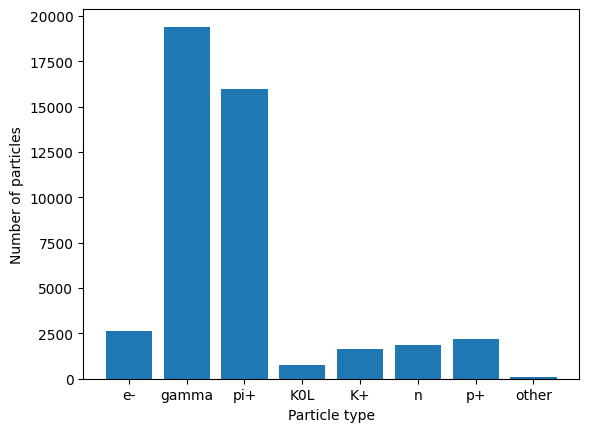

In [11]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['e-', 'gamma', 'pi+', 'K0L', 'K+', 'n', 'p+', 'other']
x = np.arange(len(labels))
width = 0.8

fig, ax = plt.subplots()
bar = ax.bar(x, particles_count.values(), width)

ax.set_ylabel('Number of particles')
ax.set_xlabel('Particle type')
ax.set_xticks(x, labels)

plt.show()

In [12]:
px = tree.GetLeaf('GeneratedParticles.momentum.x')
py = tree.GetLeaf('GeneratedParticles.momentum.y')
pz = tree.GetLeaf('GeneratedParticles.momentum.z')
E = tree.GetLeaf('GeneratedParticles.energy')

four_p = TLorentzVector()

# Electron value histograms
# TODO: Add histogram for eta
e_ptot_hist = TH1F('p_total', 'Total Momentum for Electrons Histogram', 100, 0, 100)
e_pt_hist = TH1F('p_t', 'Transverse Momentum for Electrons Histogram', 100, 0, 100)
e_theta_hist = TH1F('theta', 'Theta for Electrons Histogram', 30, 0, 3.141593)
e_eta_hist = TH1F('eta', 'Eta for Electrons Histogram', 20, -25, 25)

# Electron value graphs
# TODO: Add graph for p_total vs eta and p_t vs eta
e_ptot_theta = TGraph()
e_ptot_eta = TGraph()
e_pt_eta = TGraph()

for ev in tree:
    for i in range(px.GetLen()):
        four_p.SetPxPyPzE(px.GetValue(i),
                          py.GetValue(i),
                          pz.GetValue(i),
                          E.GetValue(i))
        if abs(int(pdg.GetValue(i))) == 11:
            e_ptot_hist.Fill(four_p.Rho())
            e_pt_hist.Fill(four_p.Pt())
            e_theta_hist.Fill(four_p.Theta())
            eta = -np.log(np.tan(four_p.Theta()))
            e_eta_hist.Fill(eta)
            
            e_ptot_theta.AddPoint(four_p.Rho(), four_p.Theta())
            e_ptot_eta.AddPoint(four_p.Rho(), eta)
            e_pt_eta.AddPoint(four_p.Pt(), eta)

/tmp/ipykernel_18541/3871200636.py:31: RuntimeWarning: invalid value encountered in log
  eta = -np.log(np.tan(four_p.Theta()))


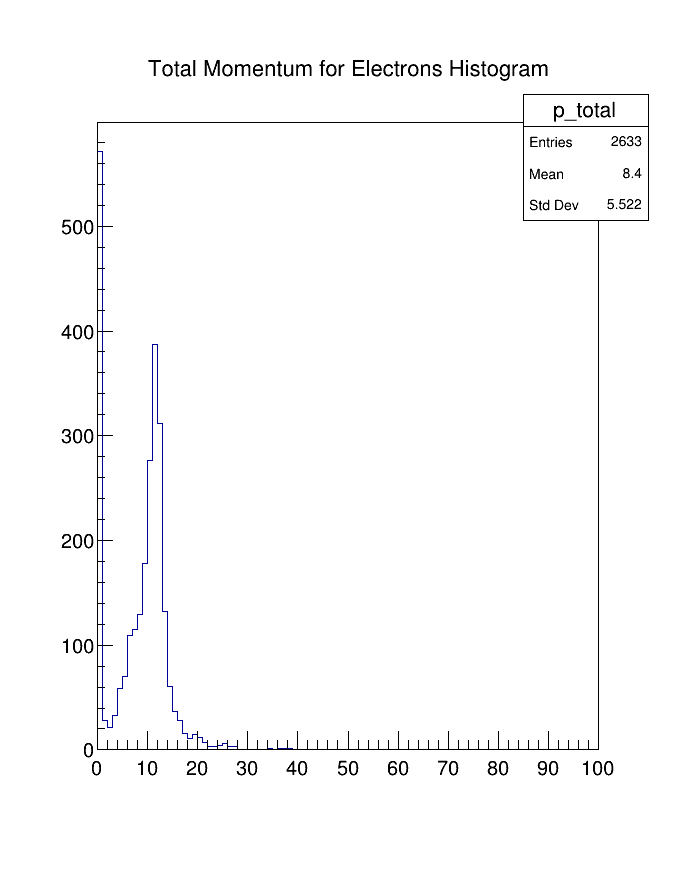

In [13]:
c_e_ptot = TCanvas('c_e_ptot', 'The canvas for total momentum', 200, 10, 700, 900)
pad_e_ptot = TPad('pad_e_ptot', 'The pad for p_total', 0.05, 0.05, 0.95, 0.95)

pad_e_ptot.Draw()
pad_e_ptot.cd()
e_ptot_hist.Draw()
c_e_ptot.Update()

c_e_ptot.Draw()

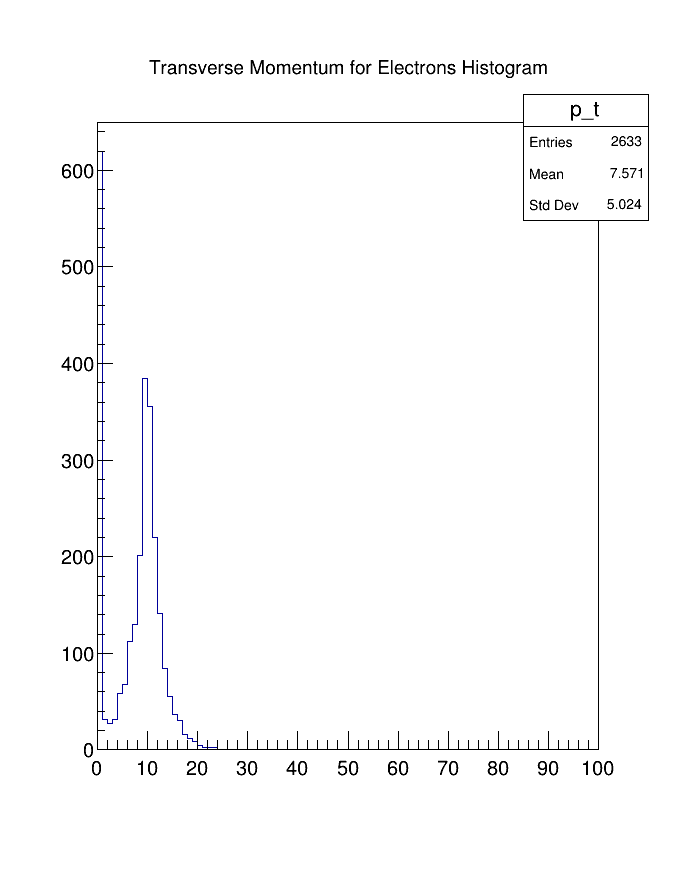

In [14]:
c_e_pt = TCanvas('c_e_pt', 'The canvas for transverse momentum', 200, 10, 700, 900)
pad_e_pt = TPad('pad_e_pt', 'The pad for p_t', 0.05, 0.05, 0.95, 0.95)

pad_e_pt.Draw()
pad_e_pt.cd()
e_pt_hist.Draw()
c_e_pt.Update()

c_e_pt.Draw()

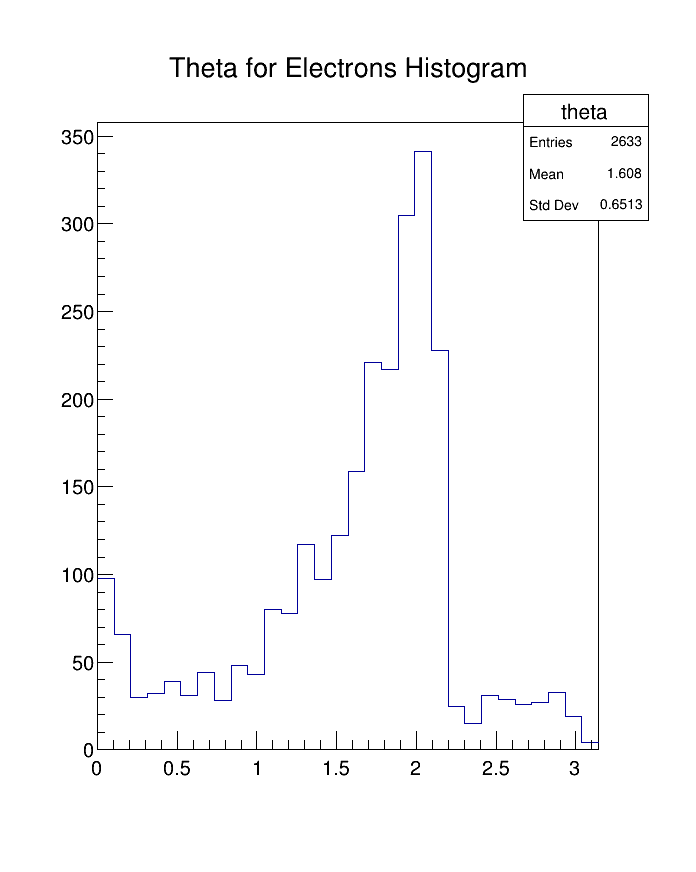

In [15]:
c_e_theta = TCanvas('c_e_theta', 'The canvas with the theta histogram', 200, 10, 700, 900)
pad_e_theta = TPad('pad_e_theta', 'The pad with theta', 0.05, 0.05, 0.95, 0.95)

pad_e_theta.Draw()
pad_e_theta.cd()
e_theta_hist.Draw()
c_e_theta.Update()

c_e_theta.Draw()

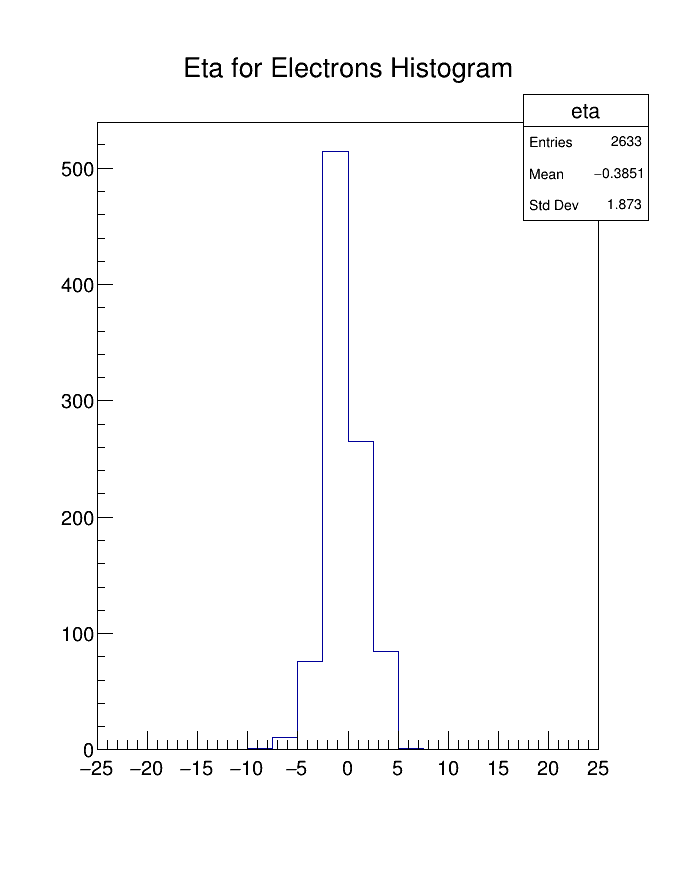

In [16]:
c_e_eta = TCanvas('c_e_eta', 'The canvas with the eta histogram', 200, 10, 700, 900)
pad_e_eta = TPad('pad_e_eta', 'The pad with eta', 0.05, 0.05, 0.95, 0.95)

pad_e_eta.Draw()
pad_e_eta.cd()
e_eta_hist.Draw()
c_e_eta.Update()

c_e_eta.Draw()

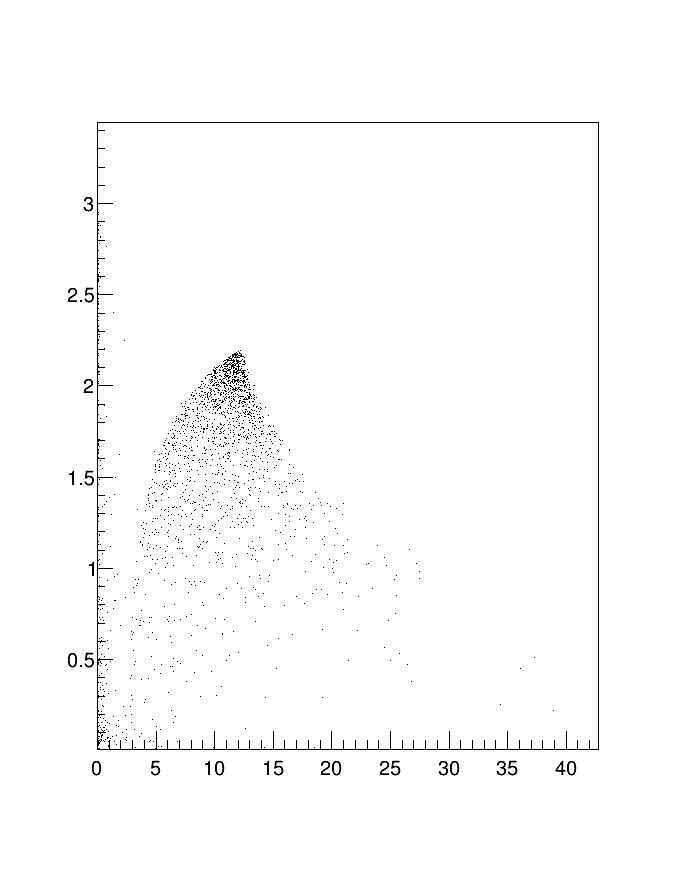

In [17]:
c_e_ptot_theta = TCanvas('c_e_ptot_theta', 'The canvas with total momentum vs theta', 200, 10, 700, 900)
pad_e_ptot_theta = TPad('pad_e_ptot_theta', 'The pad with total momentum vs theta', 0.05, 0.05, 0.95, 0.95)

pad_e_ptot_theta.Draw()
pad_e_ptot_theta.cd()
e_ptot_theta.Draw('AP')
c_e_ptot_theta.Update()

c_e_ptot_theta.Draw()

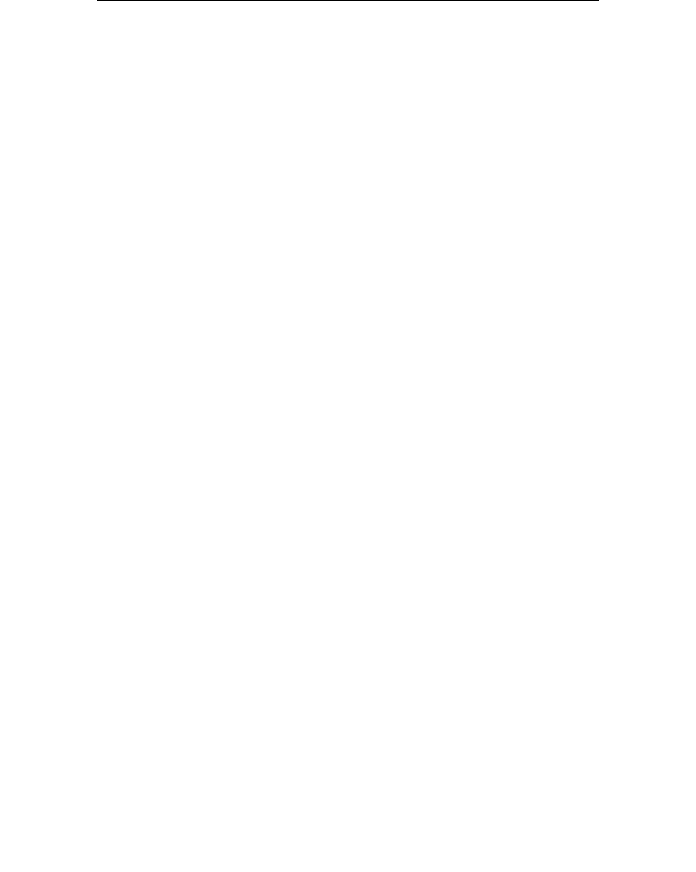

In [18]:
c_e_ptot_eta = TCanvas('c_e_ptot_eta', 'The canvas with total momentum vs eta', 200, 10, 700, 900)
pad_e_ptot_eta = TPad('pad_e_ptot_eta', 'The pad with total momentum vs eta', 0.05, 0.05, 0.95, 0.95)

pad_e_ptot_eta.Draw()
pad_e_ptot_eta.cd()
e_ptot_eta.Draw('AP')
c_e_ptot_eta.Update()

c_e_ptot_eta.Draw()

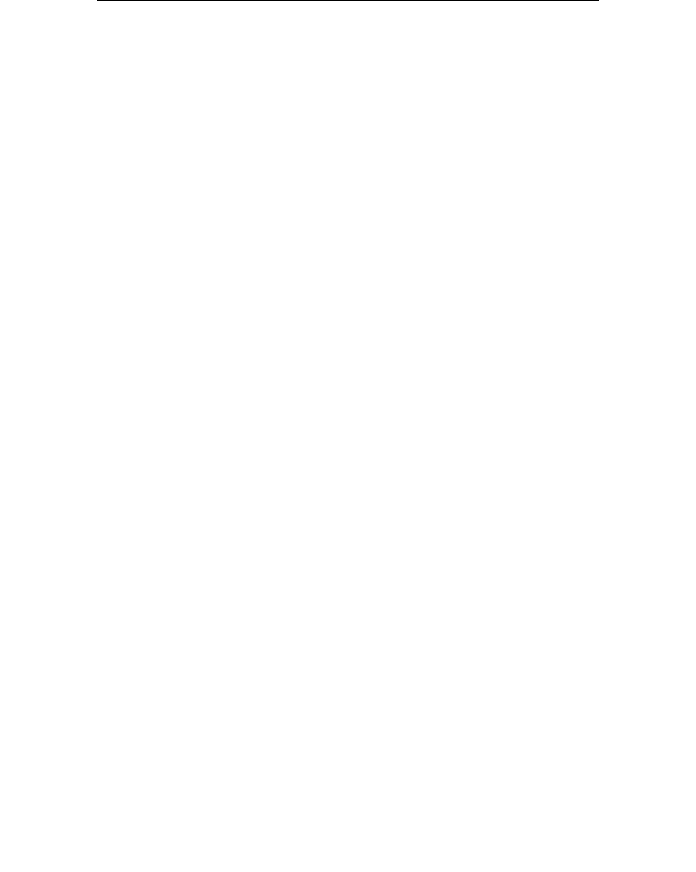

In [19]:
c_e_pt_eta = TCanvas('c_e_pt_eta', 'The canvas with transverse momentum vs eta', 200, 10, 700, 900)
pad_e_pt_eta = TPad('pad_e_pt_eta', 'The pad with transverse momentum vs eta', 0.05, 0.05, 0.95, 0.95)

pad_e_pt_eta.Draw()
pad_e_pt_eta.cd()
e_pt_eta.Draw('AP')
c_e_pt_eta.Update()

c_e_pt_eta.Draw()